# Regridding the Raw Grid to Regular Grid

## Needed package
- regional_mom6
- xarray
- netcdf4
- xesmf

:::{admonition} Techical info
:class: info
Before diving into the regridding code, let’s first define what we mean by raw grid and regular grid. The raw grid refers to the curvilinear grid used by the regional MOM6 model. This is the native grid of the model output and is what you will see if you work directly with the simulation data. To use data on the raw grid, you need both the variable file and a corresponding static file that contains the curvilinear grid information.

In contrast, the regular grid refers to a rectilinear grid commonly used in reanalysis datasets or gridded observational products. This type of grid is defined by two coordinates: longitude and latitude, which form a regular, evenly spaced grid across the globe or a specific region.
:::

## Get the data
Here we utilize the OPeNDAP THREDDS server provided by the PSL CEFI data portal. We first define all the necessary information in a dictionary. These entries typically specify the details required to access a particular dataset.


In [1]:
dict_data_info = {
    "region": "northwest_atlantic",
    "subdomain": "full_domain",
    "experiment_type": "hindcast",
    "output_frequency": "monthly",
    "grid_type": "raw",
    "release": "r20230520",
    "data_source": "opendap",
}

We use the `AccessFiles` class from the `mom6_read` module to specify the dataset information and data source. If the connection is successful, the class will return a standard message: `Success: URL ...`, indicating the URL to the dataset. This URL can also be used to browse the OPeNDAP catalog, which lists all available variables associated with the specified dataset.

In [2]:

from mom6.mom6_module.mom6_read import AccessFiles
cefi_data_access = AccessFiles(**dict_data_info)

Success: URL https://psl.noaa.gov/thredds/catalog/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/raw/r20230520/catalog.html responded with status 200.


:::{admonition} Tip
:class: info
The `**dict_data_info` syntax unpacks the key-value pairs in the dictionary and passes them as keyword arguments required to create the `cefi_data_access` object
:::

Now let's focus on a single variable - `tos`(sea surface temperature) for downloading. The way to get the variable is through the `.get()` method and by providing the keyword argument `variable='tos'` we can narrow the list down to only `tos` related file on the server for this specific dataset. `print_list` argument help the user to see if there are multiple files that has the variable name `tos`. In this case, we only have one. 

In [3]:
variable_urls = cefi_data_access.get(variable="tos",print_list=True)

--------- All avaible files ------------
https://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/raw/r20230520/tos.nwa.full.hcast.monthly.raw.r20230520.199301-201912.nc


The `variable_urls` is a list object, in this case, only one element in the list.

In [4]:
variable_urls

['https://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/raw/r20230520/tos.nwa.full.hcast.monthly.raw.r20230520.199301-201912.nc']

We can now use the URL to access the file with the power of `Xarray`

In [5]:
import xarray as xr
ds = xr.open_dataset(variable_urls[0], chunks={})

In [6]:
ds

<xarray.Dataset> Size: 849MB
Dimensions:     (time: 324, nv: 2, xh: 775, yh: 845)
Coordinates:
  * nv          (nv) float64 16B 1.0 2.0
  * time        (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-16T...
  * xh          (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh          (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
Data variables:
    average_DT  (time) timedelta64[ns] 3kB dask.array<chunksize=(324,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] 3kB dask.array<chunksize=(324,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] 3kB dask.array<chunksize=(324,), meta=np.ndarray>
    time_bnds   (time, nv) datetime64[ns] 5kB dask.array<chunksize=(324, 2), meta=np.ndarray>
    tos         (time, yh, xh) float32 849MB dask.array<chunksize=(324, 845, 775), meta=np.ndarray>
Attributes: (12/30)
    NumFilesInSet:                   1
    title:                           NWA12_COBALT_2023_04_kpo4-coastatten-phy...
    associated_files:                areacello: 19930101.ocean_static.nc
    grid_type:                       regular
    grid_tile:                       N/A
    external_variables:              areacello
    ...                              ...
    cefi_forcing:                    N/A
    cefi_data_doi:                   10.5281/zenodo.7893386
    cefi_paper_doi:                  10.5194/gmd-16-6943-2023
    cefi_aux:                        N/A
    cefi_ori_category:               ocean_monthly
    DODS_EXTRA.Unlimited_Dimension:  time

:::{admonition} Tip
:class: info
It is good practice to open files lazily when accessing data from an OPeNDAP server, as each server may have different data query limits. By using lazy loading, we initially load only the data structure and metadata. This allows us to explore the dataset and subset the data more efficiently once we know exactly what we need.
:::

Since we are doing the regridding, we only need a single time snapshot of `tos` map. Now we use the `.load()` method to grab the data from the OPeNDAP server to the local memory.

In [7]:
ds_subset = ds.isel(time=0).load()

In [8]:
ds_subset

<xarray.Dataset> Size: 3MB
Dimensions:     (nv: 2, xh: 775, yh: 845)
Coordinates:
  * nv          (nv) float64 16B 1.0 2.0
    time        datetime64[ns] 8B 1993-01-16T12:00:00
  * xh          (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh          (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
Data variables:
    average_DT  timedelta64[ns] 8B 31 days
    average_T1  datetime64[ns] 8B 1993-01-01
    average_T2  datetime64[ns] 8B 1993-02-01
    time_bnds   (nv) datetime64[ns] 16B 1993-01-01 1993-02-01
    tos         (yh, xh) float32 3MB nan nan nan nan ... 3.805 3.79 3.79 3.786
Attributes: (12/30)
    NumFilesInSet:                   1
    title:                           NWA12_COBALT_2023_04_kpo4-coastatten-phy...
    associated_files:                areacello: 19930101.ocean_static.nc
    grid_type:                       regular
    grid_tile:                       N/A
    external_variables:              areacello
    ...                              ...
    cefi_forcing:                    N/A
    cefi_data_doi:                   10.5281/zenodo.7893386
    cefi_paper_doi:                  10.5194/gmd-16-6943-2023
    cefi_aux:                        N/A
    cefi_ori_category:               ocean_monthly
    DODS_EXTRA.Unlimited_Dimension:  time

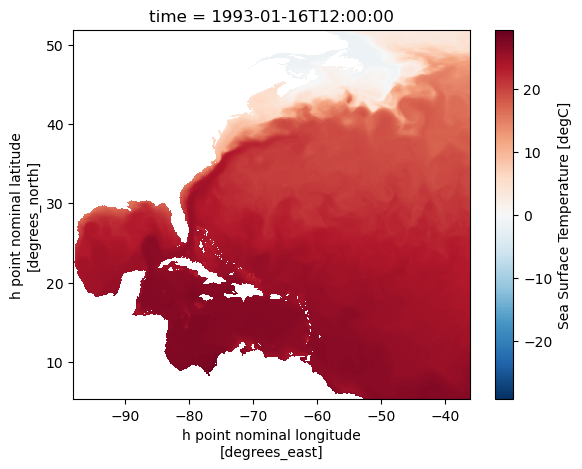

In [9]:
ds_subset['tos'].plot()

As mentioned earlier, raw grid data requires grid information provided by the model. To obtain this, we need the static file, which can be accessed using the same steps used to retrieve the variable file. The static file is typically located in the same folder, URL, or catalog as the raw data. Therefore, we can reuse the same `cefi_data_access` object created earlier for the variable field, and simply pass `variable="ocean_static"` to the `.get()` method.

In [10]:
static_urls = cefi_data_access.get(variable="ocean_static",print_list=True)

--------- All avaible files ------------
https://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/raw/r20230520/ocean_static.nc


Here, we only want to retain the necessary information from the static file, which contains many additional grid variables. In this case, we need the tracer point longitude and latitude, located on the `xh` and `yh` grid coordinates, and stored under the variable names `geolon` and `geolat`.

In [11]:
ds_static = xr.open_dataset(static_urls[0], chunks={})
ds_static = ds_static[['geolon', 'geolat']].load()

In [12]:
ds_static

<xarray.Dataset> Size: 5MB
Dimensions:  (yh: 845, xh: 775)
Coordinates:
  * xh       (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh       (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.88 51.9 51.91 51.93
Data variables:
    geolon   (yh, xh) float32 3MB -98.0 -97.92 -97.84 ... -37.36 -37.27 -37.19
    geolat   (yh, xh) float32 3MB 5.273 5.273 5.273 5.273 ... 58.15 58.16 58.16
Attributes:
    _NCProperties:                   version=2,netcdf=4.9.0,hdf5=1.12.2
    NumFilesInSet:                   1
    title:                           NWA12_MOM6_v1.0
    grid_type:                       regular
    grid_tile:                       N/A
    history:                         Fri May 12 10:50:21 2023: ncks -4 -L 3 o...
    NCO:                             netCDF Operators version 5.0.1 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

As one can see from above, the coordinate is only `xh` and `yh` now. Let's merge the static dataset with the variable dataset.

In [16]:
ds_subset_static = xr.merge([ds_subset, ds_static])

To ensure that plotting and regridding work correctly, we need to set `geolon` and `geolat` as coordinates in the merged dataset, as they are initially listed as variables after the merge.


In [17]:
ds_subset_static = ds_subset_static.set_coords(['geolon','geolat'])

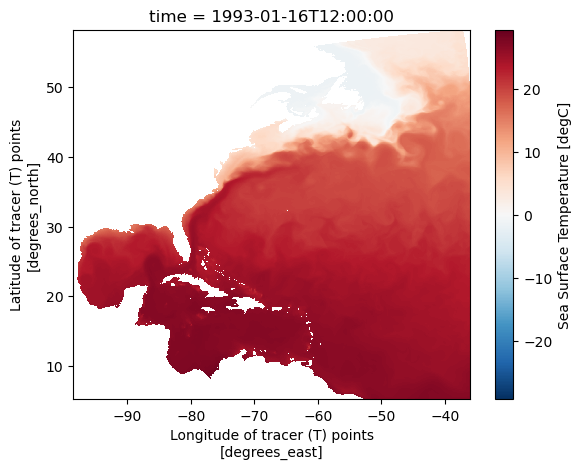

In [19]:
ds_subset_static.tos.plot(x='geolon', y='geolat')

## Regrid

To perform regridding, we use the `Regridding` class from the `mom6_regrid` module. This class requires information about the original dataset, including the variable name, as well as the names of the x and y dimension coordinates.

In [20]:
from mom6.mom6_module.mom6_regrid import Regridding

# call regridding class
class_regrid = Regridding(
    ori_dataset=ds_subset_static,
    varname='tos',
    ori_xname='geolon',
    ori_yname='geolat'
)


Once the object is created, we can use the `.regrid_regular()` method to create the regridded dataset. Here we used the spacing of 775 in x dimension and 845 in y dimension equal spacing for the new regridded dataset.

845

In [ ]:
nx = 775
ny = 845
# perform regridding
ds_regrid = class_regrid.regrid_regular(nx, ny)


### Create the regridding object
In this o

In [1]:
"""
This script is designed to do batch regridf of the 
regional mom6 output usig the new mom6_read module

The regridding is using the xesmf package with the bilinear method
there are other more conservative way to doing the regriddeding 
https://xesmf.readthedocs.io/en/stable/notebooks/Compare_algorithms.html 
"""
import os
import warnings
import xarray as xr
from mom6.data_structure import portal_data
from mom6.mom6_module.mom6_read import AccessFiles
from mom6.mom6_module.mom6_regrid import Regridding
from mom6.mom6_module.mom6_export import mom6_encode_attr

warnings.simplefilter("ignore")



In [2]:
dict_json = {
    "local_top_dir": "/Projects/CEFI/regional_mom6/",
    "region": "northwest_atlantic",
    "subdomain": "full_domain",
    "experiment_type": "hindcast",
    "output_frequency": "monthly",
    "grid_type": "raw",
    "release": "r20230520",
    "data_source": "local",
    "output": {
        "cefi_grid_type": "regrid",
        "cefi_aux": "Postprocessed Data : regrid to regular grid"
    }
}
variable_short = 'sfc_co3_ion'

In [ ]:
local_top_dir=dict_json['local_top_dir']
region=dict_json['region']
subdomain=dict_json['subdomain']
experiment_type=dict_json['experiment_type']
output_frequency=dict_json['output_frequency']
grid_type=dict_json['grid_type']
release=dict_json['release']
data_source=dict_json['data_source']

# determine the data path
output_cefi_rel_path = portal_data.DataPath(
    region=region,
    subdomain=subdomain,
    experiment_type=experiment_type,
    output_frequency=output_frequency,
    grid_type=dict_json['output']['cefi_grid_type'],
    release=dict_json['release']
).cefi_dir

output_dir = os.path.join(local_top_dir,output_cefi_rel_path)


# get all files in the experiment
local_access = AccessFiles(
    local_top_dir=local_top_dir,
    region=region,
    subdomain=subdomain,
    experiment_type=experiment_type,
    output_frequency=output_frequency,
    grid_type=grid_type,
    release=release,
    data_source=data_source
)

allfile_list = local_access.get()
statics = local_access.get(variable='ocean_static')
try:
    ice_statics = local_access.get(variable='ice_monthly')
except FileNotFoundError:
    print("ice_monthly static file not found")

# prepare static data
try:
    ds_static = xr.open_dataset(statics[0]).drop_vars('time') # time dim not needed
except ValueError:
    ds_static = xr.open_dataset(statics[0])

try:
    ds_static_ice = xr.open_dataset(ice_statics[0])
except Exception as e:
    ds_static_ice = None

# loop through all file in the original path
for file in allfile_list:
    # try to avoid the static file
    if 'static' not in file and variable_short in file:
        print(file)
        # open the file
        with xr.open_dataset(file, chunks={}) as ds_var:
            ds_var = ds_var.isel(time=0).load()
            varname = ds_var.attrs['cefi_variable']

            # create new filename based on original filename
            filename = ds_var.attrs['cefi_filename']
            filename_seg = filename.split('.')
            grid_type_index = filename_seg.index('raw')
            filename_seg[grid_type_index] = dict_json['output']['cefi_grid_type']
            new_filename = '.'.join(filename_seg)

            # find if new file name already exist
            new_file = os.path.join(output_dir, new_filename)
            

            # get xname and yname (need expand if there are other grids)
            dims = list(ds_var.dims)
            if all(dim in dims for dim in ['xq', 'yh']):
                xname = 'geolon_u'
                yname = 'geolat_u'
                xdimorder = dims.index('xq')
                ydimorder = dims.index('yh')
                # stop regrid due to u grid need rotation first
                print("Skipping file due to UGRID need rotation first")
                continue
            elif all(dim in dims for dim in ['xh', 'yh']):
                # currently only support tracer grid regridding
                xname = 'geolon'
                yname = 'geolat'
                xdimorder = dims.index('xh')
                ydimorder = dims.index('yh')
                # merge static field to include lon lat info
                ds_var = xr.merge([ds_var, ds_static], combine_attrs='override')
            elif all(dim in dims for dim in ['xh', 'yq']):
                xname = 'geolon_v'
                yname = 'geolat_v'
                xdimorder = dims.index('xh')
                ydimorder = dims.index('yq')
                # stop regrid due to v grid need rotation first
                print("Skipping file due to VGRID need rotation first")
                continue
            elif all(dim in dims for dim in ['xT', 'yT']):
                if ds_static_ice is None:
                    print("Skipping file due to ice static field not found")
                    continue
                # ice month static field replace
                # currently only support ice tracer grid regridding
                xname = 'GEOLON'
                yname = 'GEOLAT'
                xdimorder = dims.index('xT')
                ydimorder = dims.index('yT')
                # merge static field to include lon lat info
                ds_var = xr.merge([ds_var, ds_static_ice], combine_attrs='override')
            else:
                try:
                    raise ValueError("Unknown grid (need implementations)")
                except ValueError as e:
                    print(f"Skipping file due to error: {e}")
                    continue

            # call regridding class
            class_regrid = Regridding(ds_var, varname, xname, yname)
            nx = len(ds_var[dims[xdimorder]])
            ny = len(ds_var[dims[ydimorder]])
            # perform regridding
            ds_regrid = class_regrid.regrid_regular(nx, ny)
            # forecast/reforecast files has two varname in one single file
            try:
                class_regrid_anom = Regridding(ds_var, varname + '_anom', xname, yname)
                # perform regridding
                ds_regrid_anom = class_regrid_anom.regrid_regular(nx, ny)
                ds_regrid = xr.merge([ds_regrid, ds_regrid_anom])
            except KeyError:
                pass

            # copy the encoding and attributes
            ds_regrid = mom6_encode_attr(ds_var, ds_regrid, var_names=[varname])

            # redefine new global attribute
            # global attributes

            # create new cefi_rel_path based on original cefi_rel_path
            filepath = ds_var.attrs['cefi_rel_path']
            filepath_seg = filepath.split('/')

            # Change 'raw' to 'regrid'
            for i, element in enumerate(filepath_seg):
                if element == 'raw':
                    filepath_seg[i] = dict_json['output']['cefi_grid_type']

            new_cefi_rel_path = '/'.join(filepath_seg)

            ds_regrid.attrs['cefi_rel_path'] = new_cefi_rel_path
            ds_regrid.attrs['cefi_filename'] = new_filename
            ds_regrid.attrs['cefi_grid_type'] = dict_json['output']['cefi_grid_type']

ice_monthly static file not found
/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/raw/r20230520/sfc_co3_ion.nwa.full.hcast.monthly.raw.r20230520.199301-201912.nc


In [8]:
ds_regrid.to_netcdf(f'{variable_short}_test.nc', mode='w', format='NETCDF4')

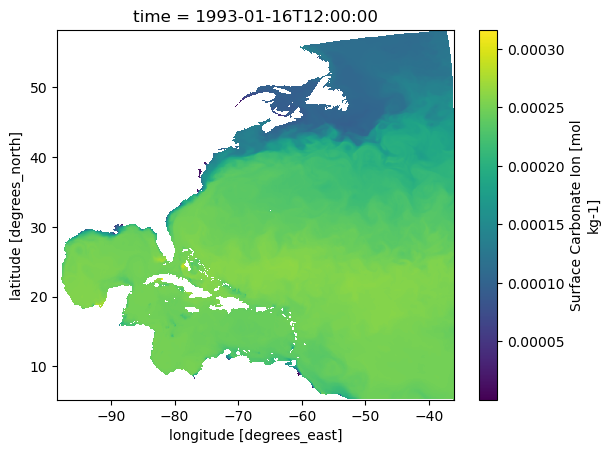

In [9]:
ds_regrid[variable_short].plot()

In [23]:
ds_old = xr.open_dataset('/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/regrid/r20230520/tob.nwa.full.hcast.monthly.regrid.r20230520.199301-201912.nc')

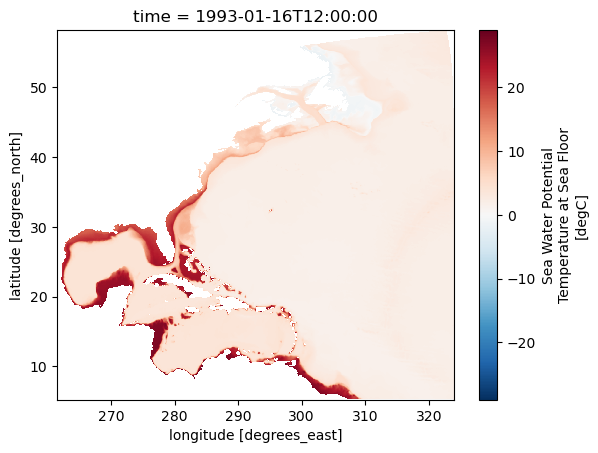

In [25]:
ds_old.tob.isel(time=0).plot()

In [27]:
ds_old.tob.isel(time=0)

<xarray.DataArray 'tob' (lat: 844, lon: 774)> Size: 3MB
[653256 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 7kB 5.273 5.335 5.398 5.461 ... 58.04 58.1 58.16
  * lon      (lon) float64 6kB 261.6 261.6 261.7 261.8 ... 323.8 323.8 323.9
    time     datetime64[ns] 8B 1993-01-16T12:00:00
Attributes:
    units:          degC
    long_name:      Sea Water Potential Temperature at Sea Floor
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature_at_sea_floor

In [29]:
ds_regrid['lon'] = ds_regrid['lon']+360.
ds_regrid.tob.isel(time=0)

<xarray.DataArray 'tob' (lat: 844, lon: 774)> Size: 3MB
dask.array<getitem, shape=(844, 774), dtype=float32, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 1993-01-16T12:00:00
  * lon      (lon) float64 6kB 261.6 261.6 261.7 261.8 ... 323.8 323.8 323.9
  * lat      (lat) float64 7kB 5.273 5.335 5.398 5.461 ... 58.04 58.1 58.16
Attributes:
    regrid_method:  bilinear
    units:          degC
    long_name:      Sea Water Potential Temperature at Sea Floor
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature_at_sea_floor

In [ ]:
(ds_regrid.tob.isel(time=0)-ds_old.tob.isel(time=0)).plot()

In [17]:
ds_var

<xarray.Dataset> Size: 914MB
Dimensions:       (time: 324, nv: 2, yh: 845, xh: 775, yq: 846, xq: 776)
Coordinates:
  * nv            (nv) float64 16B 1.0 2.0
  * time          (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-1...
  * xh            (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh            (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
  * xq            (xq) float64 6kB -98.04 -97.96 -97.88 ... -36.2 -36.12 -36.04
  * yq            (yq) float64 7kB 5.233 5.312 5.392 5.472 ... 51.9 51.92 51.94
Data variables: (12/30)
    average_DT    (time) timedelta64[ns] 3kB dask.array<chunksize=(100,), meta=np.ndarray>
    average_T1    (time) datetime64[ns] 3kB dask.array<chunksize=(100,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] 3kB dask.array<chunksize=(100,), meta=np.ndarray>
    time_bnds     (time, nv) datetime64[ns] 5kB dask.array<chunksize=(100, 2), meta=np.ndarray>
    tob           (time, yh, xh) float32 849MB dask.array<chunksize=(100, 200, 200), meta=np.ndarray>
    Coriolis      (yq, xq) float32 3MB ...
    ...            ...
    geolon_v      (yq, xh) float32 3MB ...
    sftof         (yh, xh) float32 3MB ...
    wet           (yh, xh) float32 3MB ...
    wet_c         (yq, xq) float32 3MB ...
    wet_u         (yh, xq) float32 3MB ...
    wet_v         (yq, xh) float32 3MB ...
Attributes: (12/28)
    NumFilesInSet:          1
    title:                  NWA12_COBALT_2023_04_kpo4-coastatten-physics
    associated_files:       areacello: 19930101.ocean_static.nc
    grid_type:              regular
    grid_tile:              N/A
    external_variables:     areacello
    ...                     ...
    cefi_ensemble_info:     N/A
    cefi_forcing:           N/A
    cefi_data_doi:          10.5281/zenodo.7893386
    cefi_paper_doi:         10.5194/gmd-16-6943-2023
    cefi_aux:               N/A
    cefi_ori_category:      ocean_monthly